In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import pandas as pd
from src.gpt_prompt import get_sentiment_general, get_sentiment_general_parallel, get_risk_score
import datetime

In [2]:
df_news = pd.read_csv("../data/apple_2022/news_apple_2022.csv", index_col=0)
df_price = pd.read_csv("../data/apple_2022/price_apple_2022.csv", index_col=0)
df_news["date"] = pd.to_datetime(df_news['date'])
df_price["date"] = pd.to_datetime(df_price['date'])
print(df_news.head())
print(df_price.head())

                 date                                               news
0 2022-01-01 00:32:44  I actually lost weight this holiday season — t...
1 2022-01-01 00:52:34  January Dogs Of The Dow Need A PullbackThirty-...
2 2022-01-01 01:04:02  I switched from Android to iPhone — here's wha...
3 2022-01-01 01:36:26  365 Inspirational Quotes for 2022Inspiring, po...
4 2022-01-01 02:06:21  Is Fitbit Premium worth it? Here's the pros an...
                 date       price
0 2022-01-03 09:31:00  175.826576
1 2022-01-03 09:32:00  176.596792
2 2022-01-03 09:33:00  176.636290
3 2022-01-03 09:34:00  176.776509
4 2022-01-03 09:35:00  176.705412


In [3]:
dfs = []
for i in range(1, 6):
    df_score = pd.read_csv(f"../data/apple_2022/news_score_apple_2022_{i}.csv", index_col=0)
    print(df_score.shape)
    df_score = df_score[["date", "score"]]
    df_score["date"] = pd.to_datetime(df_score['date'])
    dfs.append(df_score)
    
df_score = pd.concat(dfs)
df_score.reset_index(drop = True, inplace = True)
df_score.to_csv("../data/apple_2022/news_score_apple_2022_all.csv")
df_score


# df_score = pd.read_csv(f"../data/apple_2022/news_score_apple_2022_{1}.csv", index_col=0)
# print(df_score.shape)
# df_score = df_score[["date", "score"]]
# df_score["date"] = pd.to_datetime(df_score['date'])

(439, 3)
(1096, 3)
(4000, 3)
(3200, 3)
(1800, 3)


,date,score
0,2022-01-01 00:32:44,0
1,2022-01-03 08:16:20,1
2,2022-01-03 15:35:48,-1
3,2022-01-04 05:49:27,1
4,2022-01-04 10:47:02,0
...,...,...
10530,2022-06-28 21:51:40,0
10531,2022-06-29 01:45:58,-1
10532,2022-06-29 04:46:26,-1
10533,2022-06-29 06:31:43,1


In [4]:
df_score = df_score.sort_values("date")
df_score.reset_index(drop = True, inplace = True)
df_score

,date,score
0,2022-01-01 00:32:44,0
1,2022-01-01 00:52:34,1
2,2022-01-01 01:04:02,0
3,2022-01-01 01:36:26,0
4,2022-01-01 07:26:01,1
...,...,...
10530,2022-12-29 20:16:15,0
10531,2022-12-30 07:02:20,1
10532,2022-12-30 16:50:34,-1
10533,2022-12-31 02:03:24,0


In [5]:
df_score["score"].value_counts()

 1    6386
 0    2284
-1    1860
 5       5
Name: score, dtype: int64

In [6]:
date_price_dict = df_price.set_index('date')['price'].to_dict()
# date_price_dict

In [7]:
def find_whole_minute_time_after_n_minutes(time, n):
    new_time = time + pd.Timedelta(minutes=n)
    if new_time.second > 0:
        new_time += pd.Timedelta(minutes=1)
        new_time = new_time.replace(second=0, microsecond=0)
    return new_time

In [8]:
df_news.shape

(43832, 2)

In [9]:

columns = [f"price_in_{i}" for i in range(61)]
deltas = [i for i in range(61)]
pd_price = np.zeros((df_news.shape[0], 61))

for i in range(df_news.shape[0]):
    time = df_news["date"][i]
    for j in range(61):
        delta = deltas[j]
        new_time = find_whole_minute_time_after_n_minutes(time, delta)
        if new_time in date_price_dict:
            pd_price[i, j] = date_price_dict[new_time]

In [10]:
date_price_dict

{Timestamp('2022-01-03 09:31:00'): 175.826575614,
 Timestamp('2022-01-03 09:32:00'): 176.596791996,
 Timestamp('2022-01-03 09:33:00'): 176.636290272,
 Timestamp('2022-01-03 09:34:00'): 176.7765091518,
 Timestamp('2022-01-03 09:35:00'): 176.705412255,
 Timestamp('2022-01-03 09:36:00'): 177.031273032,
 Timestamp('2022-01-03 09:37:00'): 177.386757516,
 Timestamp('2022-01-03 09:38:00'): 178.018729932,
 Timestamp('2022-01-03 09:39:00'): 177.890360535,
 Timestamp('2022-01-03 09:40:00'): 178.068102777,
 Timestamp('2022-01-03 09:41:00'): 177.969357087,
 Timestamp('2022-01-03 09:42:00'): 178.087851915,
 Timestamp('2022-01-03 09:43:00'): 178.275468726,
 Timestamp('2022-01-03 09:44:00'): 178.43346183,
 Timestamp('2022-01-03 09:45:00'): 178.33471614,
 Timestamp('2022-01-03 09:46:00'): 178.206346743,
 Timestamp('2022-01-03 09:47:00'): 178.127350191,
 Timestamp('2022-01-03 09:48:00'): 177.64349631,
 Timestamp('2022-01-03 09:49:00'): 177.525001482,
 Timestamp('2022-01-03 09:50:00'): 177.682994586,
 T

In [11]:
pd_price = pd.DataFrame(pd_price, columns=columns)
result_df = pd.concat([df_news, pd_price], axis=1)

In [12]:
result_df

,date,news,price_in_0,price_in_1,price_in_2,price_in_3,price_in_4,price_in_5,price_in_6,price_in_7,...,price_in_51,price_in_52,price_in_53,price_in_54,price_in_55,price_in_56,price_in_57,price_in_58,price_in_59,price_in_60
0,2022-01-01 00:32:44,I actually lost weight this holiday season — t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-01 00:52:34,January Dogs Of The Dow Need A PullbackThirty-...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-01 01:04:02,I switched from Android to iPhone — here's wha...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-01 01:36:26,"365 Inspirational Quotes for 2022Inspiring, po...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-01 02:06:21,Is Fitbit Premium worth it? Here's the pros an...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43827,2022-12-31 19:01:02,The Fall Of Tesla And The Rise of Exxon Amid T...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43828,2022-12-31 21:34:25,Elon Musk becomes first person ever to lose $U...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43829,2022-12-31 21:36:15,Elon Musk becomes first person ever to lose $U...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43830,2022-12-31 23:02:20,I love my Kindle but I’m turning it off this s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_score

,date,score
0,2022-01-01 00:32:44,0
1,2022-01-01 00:52:34,1
2,2022-01-01 01:04:02,0
3,2022-01-01 01:36:26,0
4,2022-01-01 07:26:01,1
...,...,...
10530,2022-12-29 20:16:15,0
10531,2022-12-30 07:02:20,1
10532,2022-12-30 16:50:34,-1
10533,2022-12-31 02:03:24,0


In [14]:
result_df.replace(0, pd.NA, inplace=True)
result_df = result_df.merge(df_score, on='date', how='left')
result_df["score"] = result_df["score"].astype(float)
result_df = result_df.dropna()



return_cols = [f"return_in_{i}" for i in range(1,61)]
price_cols = [f"price_in_{i}" for i in range(61)]

for i in range(60):
    result_df[return_cols[i]] = (result_df[price_cols[i]] - result_df["price_in_0"]) / result_df["price_in_0"]
    result_df[return_cols[i]] = result_df[return_cols[i]].astype(float)
for col in price_cols:
    result_df.drop(col, axis=1, inplace=True)
result_df = result_df.dropna()
result_df

,date,news,score,return_in_1,return_in_2,return_in_3,return_in_4,return_in_5,return_in_6,return_in_7,...,return_in_51,return_in_52,return_in_53,return_in_54,return_in_55,return_in_56,return_in_57,return_in_58,return_in_59,return_in_60
113,2022-01-03 09:39:53,Apple's wearable gadget business grew like gan...,1.0,0.0,-0.000555,0.000111,0.001165,0.002052,0.001497,0.000776,...,0.002828,0.002163,0.001941,0.002884,0.003438,0.003549,0.002828,0.003272,0.003216,0.002939
121,2022-01-03 10:04:28,My 3 Favorite ETFs to Own in 2022These three E...,1.0,0.0,0.000055,0.001381,0.001215,0.000828,0.000552,0.001546,...,0.000276,-0.000718,-0.000110,-0.000276,-0.000442,-0.000663,-0.000828,-0.001104,-0.001822,-0.002430
122,2022-01-03 10:16:38,Wacom's One 13-inch drawing tablet upgrades yo...,1.0,0.0,-0.000718,-0.000221,-0.001215,-0.002320,-0.002872,-0.002458,...,-0.001657,-0.002044,-0.002872,-0.002403,-0.002762,-0.002430,-0.001823,-0.000994,-0.001326,-0.001933
123,2022-01-03 10:22:45,Water Ways Technologies Strengthens its Board ...,1.0,0.0,0.000028,0.000526,0.001689,0.001356,0.001966,0.001744,...,0.000637,0.001467,0.001135,0.000526,0.000969,0.001356,0.001799,0.001910,0.002353,0.002215
132,2022-01-03 11:13:34,Roblox And The Sentiment MonsterThe price acti...,0.0,0.0,-0.000332,-0.000940,-0.000498,-0.000111,0.000332,0.000442,...,0.002985,0.003207,0.002488,0.002571,0.002377,0.001935,0.002322,0.002598,0.001935,0.001741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43041,2022-12-22 10:37:25,SPY And QQQ: Sleighin' Or Getting Slayed?Lofty...,1.0,0.0,-0.001902,-0.001369,-0.001750,0.000456,0.001331,0.000913,...,0.001750,0.001522,0.001446,0.001369,0.001674,0.000761,0.001065,0.001369,0.001902,0.001978
43361,2022-12-27 11:18:45,Charter's (CHTR) Slow Internet Customer Growth...,-1.0,0.0,-0.000077,-0.001468,-0.001081,-0.001081,0.000386,0.002240,...,0.005330,0.005484,0.006257,0.007802,0.007493,0.007570,0.007493,0.006334,0.006411,0.005639
43481,2022-12-28 11:37:34,Netflix's (NFLX) Glass Onion Hits the Right Ch...,1.0,0.0,-0.000118,0.000944,0.001180,0.000629,0.000551,-0.000157,...,-0.001731,-0.001967,-0.002321,-0.001652,-0.001928,-0.001652,-0.001101,-0.001101,-0.000865,-0.001023
43500,2022-12-28 13:18:25,"Stocks making the biggest moves midday: Tesla,...",0.0,0.0,-0.000235,-0.001173,-0.002190,-0.002347,-0.003520,-0.003286,...,-0.006493,-0.006806,-0.006767,-0.007041,-0.006806,-0.005945,-0.005163,-0.006728,-0.006571,-0.006297


In [15]:
result_df = result_df.dropna()

In [16]:
result_df.describe(include='all')

/var/folders/v0/_fszh3l96cz8c79p9psn63y80000gn/T/ipykernel_48035/3235814888.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  result_df.describe(include='all')


,date,news,score,return_in_1,return_in_2,return_in_3,return_in_4,return_in_5,return_in_6,return_in_7,...,return_in_51,return_in_52,return_in_53,return_in_54,return_in_55,return_in_56,return_in_57,return_in_58,return_in_59,return_in_60
count,3048,3048,3048.000000,3048.0,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,...,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000
unique,3046,3027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2022-11-14 11:02:40,Regulatory Framework for E-cigarettes Essentia...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2022-01-03 09:39:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-12-29 12:08:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.493438,0.0,0.000009,-0.000021,0.000013,0.000035,0.000022,0.000012,...,0.000008,-0.000011,-0.000032,-0.000065,-0.000086,-0.000112,-0.000118,-0.000133,-0.000151,-0.000159
std,NaN,NaN,0.755218,0.0,0.000919,0.001283,0.001573,0.001856,0.002070,0.002225,...,0.005828,0.005908,0.005981,0.006004,0.006034,0.006072,0.006155,0.006222,0.006294,0.006368
min,NaN,NaN,-1.000000,0.0,-0.004979,-0.007494,-0.009746,-0.011936,-0.013666,-0.014049,...,-0.028104,-0.028385,-0.028198,-0.029037,-0.031572,-0.031706,-0.030973,-0.030099,-0.031676,-0.032568
25%,NaN,NaN,0.000000,0.0,-0.000482,-0.000674,-0.000795,-0.000889,-0.000994,-0.001074,...,-0.003241,-0.003326,-0.003268,-0.003357,-0.003414,-0.003460,-0.003413,-0.003472,-0.003475,-0.003540


In [17]:
result_df[result_df['score'] == i][f"return_in_{j}"].mean()

nan

In [18]:
# import seaborn as sns
# for return_col in ['return_in_5', 'return_in_10', 'return_in_20', 'return_in_60']:
#     sns.scatterplot(x='score', y=return_col, data=result_df, alpha=0.1)
#     plt.title(f'Score vs {return_col}')
#     plt.show()

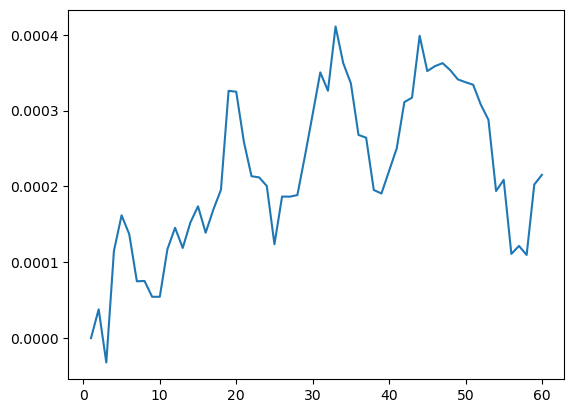

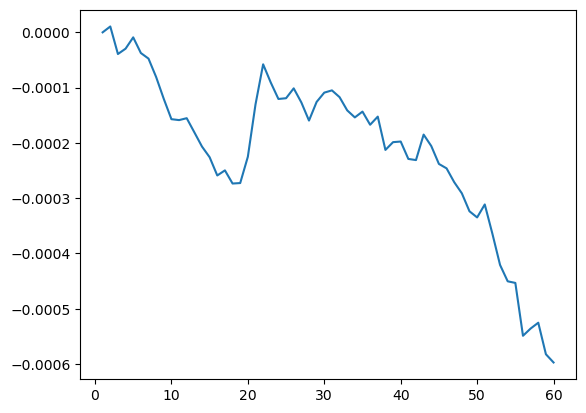

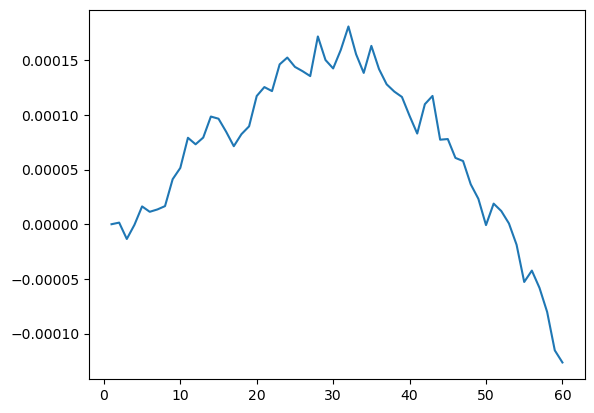

In [20]:
import matplotlib.pyplot as plt
for i in [-1, 0, 1]:
    arr = []
    for j in range(1, 61):
        avg_return = result_df[result_df['score'] == i][f"return_in_{j}"].mean()
        arr.append(avg_return)
    plt.plot(list(range(1,61)), arr)
    